## This Notebook is for testing testing code and modules

In [1]:
import logging
logging.basicConfig(filename="debugging_nb.log",
                    level=logging.DEBUG,
                    format="%(asctime)s:%(levelname)s:%(message)s"
                   )

debug_nb = logging.getLogger("Debugging_nb")
#downSampler_logger = logging.getLogger("downSampler")
#downSampler_logger.debug("Import libraries loaded")
debug_nb.debug(50*'-'+' Start of new run: Debugging_Test Notebook '+'-'*50)

In [17]:
import os
import sys
from pathlib import Path

%load_ext autoreload
%autoreload 2

module_path = os.path.abspath(os.path.join('..')) # add the projects src code directory to the sys path to allow finding our module
if module_path not in sys.path:
    sys.path.append(module_path+"\\src\\data")
    #sys.path.insert(0, module_path+"\\src\\data")
    

import downSampler # load pipeline module

import json
import h5py
import gdal
gdal.UseExceptions()
import itertools
import pystac
import geojson as gj
import numpy as np
import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
%aimport

Modules to reload:
all-except-skipped

Modules to skip:



## Read in Data files

In [4]:
input_data_path = Path(os.getcwd()).parents[0] / 'data' / 'pipeline_input' / 'debug_input' # path to input data files
output_data_path = Path(os.getcwd()).parents[0] / 'data' / 'pipeline_output' / 'debug_output' # path to output data files

input_file_dict  = downSampler.find_files(input_data_path)
#input_file_dict
output_file_dict = downSampler.find_files(output_data_path)
#output_file_dict

Finding data files...
Finding data files...


### Input files:

In [5]:
input_file_dict

{'NEON_D06_UKFS_DP3_305000_4323000_reflectance.h5': 'C:\\Users\\Chris\\Documents\\SideProjects_C\\hyperspectral-project\\data\\pipeline_input\\debug_input\\RAW Already downsampled (Gen 1)-20210610T171626Z-001\\RAW Already downsampled (Gen 1)\\NEON_D06_UKFS_DP3_305000_4323000_reflectance.h5',
 'NEON_D06_UKFS_DP3_306000_4321000_reflectance.h5': 'C:\\Users\\Chris\\Documents\\SideProjects_C\\hyperspectral-project\\data\\pipeline_input\\debug_input\\RAW Already downsampled (Gen 1)-20210610T171626Z-001\\RAW Already downsampled (Gen 1)\\NEON_D06_UKFS_DP3_306000_4321000_reflectance.h5',
 'NEON_D06_UKFS_DP3_306000_4322000_reflectance.h5': 'C:\\Users\\Chris\\Documents\\SideProjects_C\\hyperspectral-project\\data\\pipeline_input\\debug_input\\RAW Already downsampled (Gen 1)-20210610T171626Z-001\\RAW Already downsampled (Gen 1)\\NEON_D06_UKFS_DP3_306000_4322000_reflectance.h5'}

### Output files:

In [6]:
output_file_dict

{}

In [7]:
in_keys_ls = list(input_file_dict.keys())
in_keys_ls
# next(iter(input_file_dict)) alternative way
try:
    downSampler.h5dump(input_file_dict[in_keys_ls[0]])
except IndexError:
    print('input_file_dict is empty')
    
print("-"*75)
out_keys_ls = list(output_file_dict.keys())
out_keys_ls
# next(iter(input_file_dict)) alternative way
try:
    downSampler.h5dump(output_file_dict[out_keys_ls[0]])
except IndexError:
    print('output_file_dict is empty')

	 - UKFS : <HDF5 group "/UKFS" (1 members)>
		 - Reflectance : <HDF5 group "/UKFS/Reflectance" (2 members)>
			 - Metadata : <HDF5 group "/UKFS/Reflectance/Metadata" (7 members)>
				 - Ancillary_Imagery : <HDF5 group "/UKFS/Reflectance/Metadata/Ancillary_Imagery" (14 members)>
					 - Aerosol_Optical_Depth : <HDF5 dataset "Aerosol_Optical_Depth": shape (1000, 1000), type "<i2">
							 - Band_Names : AOT (aerosol optical thickness at 550 nm)*1000
							 - Data_Ignore_Value : -9999.0
							 - Description : Aerosol Optical Depth at 500 nm.
							 - Scale_Factor : 1000.0
							 - Units : Aerosol Optical Depth at 500 nm.
					 - Aspect : <HDF5 dataset "Aspect": shape (1000, 1000), type "<f4">
							 - Data_Ignore_Value : -9999.0
							 - Description : Aspect used as input to ATCOR
							 - Dimension_Labels : -
							 - Scale_Factor : 1.0
							 - Units : degrees
					 - Cast_Shadow : <HDF5 dataset "Cast_Shadow": shape (1000, 1000), type "|u1">
							 - Data_Ignore_Value : -9999.

### Read in one NEON hdf5 file

In [8]:
input_file_dict[in_keys_ls[0]]

'C:\\Users\\Chris\\Documents\\SideProjects_C\\hyperspectral-project\\data\\pipeline_input\\debug_input\\RAW Already downsampled (Gen 1)-20210610T171626Z-001\\RAW Already downsampled (Gen 1)\\NEON_D06_UKFS_DP3_305000_4323000_reflectance.h5'

In [9]:
refl_array, wavelength_array, FWHM_array, metadata_dict = downSampler.h5data2array(input_file_dict[in_keys_ls[0]])

### Checks on reflectance array just read in from hdf5 file

In [19]:
refl_array

array([[[0.013 , 0.0172, 0.0218, ..., 0.2427, 0.4996, 1.    ],
        [0.0111, 0.0153, 0.0203, ..., 0.2076, 0.5477, 1.    ],
        [0.0103, 0.0154, 0.0167, ..., 0.1546, 0.5052, 1.    ],
        ...,
        [0.006 , 0.005 , 0.0088, ..., 0.078 , 0.1324, 0.4196],
        [0.0037, 0.0114, 0.0086, ..., 0.1027, 0.134 , 0.3636],
        [0.0045, 0.009 , 0.0041, ..., 0.0909, 0.1315, 0.4435]],

       [[0.0124, 0.0223, 0.0192, ..., 0.2727, 0.3464, 1.    ],
        [0.0123, 0.0163, 0.0178, ..., 0.2893, 0.5598, 1.    ],
        [0.0126, 0.015 , 0.0164, ..., 0.2905, 0.6341, 1.    ],
        ...,
        [0.0055, 0.0097, 0.0108, ..., 0.0809, 0.12  , 0.2768],
        [0.0039, 0.0079, 0.0088, ..., 0.0331, 0.1571, 0.2535],
        [0.0047, 0.0092, 0.009 , ..., 0.0562, 0.1371, 0.2704]],

       [[0.0131, 0.0154, 0.0163, ..., 0.1414, 0.332 , 1.    ],
        [0.0122, 0.0154, 0.0157, ..., 0.2588, 0.4938, 1.    ],
        [0.0115, 0.0123, 0.0142, ..., 0.1295, 0.4555, 1.    ],
        ...,
        [0.0

In [20]:
# input image - look at first 25 bands
for band in range(25): #refl_array.shape[2]):
    print('-'*30)
    print('Band: ', band)
    print('Max: ', refl_array[:,:,band].max())
    print('Min: ', refl_array[:,:,band].min())
    print('Avg.: ', np.average(refl_array[:,:,band]))
    print('Std.: ', np.std(refl_array[:,:,band]))
    

------------------------------
Band:  0
Max:  0.2973
Min:  0.0
Avg.:  0.013437571799999999
Std.:  0.014435464564739327
------------------------------
Band:  1
Max:  0.4453
Min:  0.0
Avg.:  0.0214436159
Std.:  0.01829313999900693
------------------------------
Band:  2
Max:  0.487
Min:  0.0
Avg.:  0.021428015200000015
Std.:  0.019467136438330344
------------------------------
Band:  3
Max:  0.5737
Min:  0.0
Avg.:  0.023427503599999996
Std.:  0.021920409360502078
------------------------------
Band:  4
Max:  0.5567
Min:  0.0
Avg.:  0.019718193300000006
Std.:  0.021332163621016857
------------------------------
Band:  5
Max:  0.5561
Min:  0.0
Avg.:  0.020103421399999995
Std.:  0.022288895524319327
------------------------------
Band:  6
Max:  0.6535
Min:  0.0005
Avg.:  0.02283173619999998
Std.:  0.024645200832081073
------------------------------
Band:  7
Max:  0.6936
Min:  0.0001
Avg.:  0.022045144300000003
Std.:  0.02462075545067977
------------------------------
Band:  8
Max:  0.719
Mi

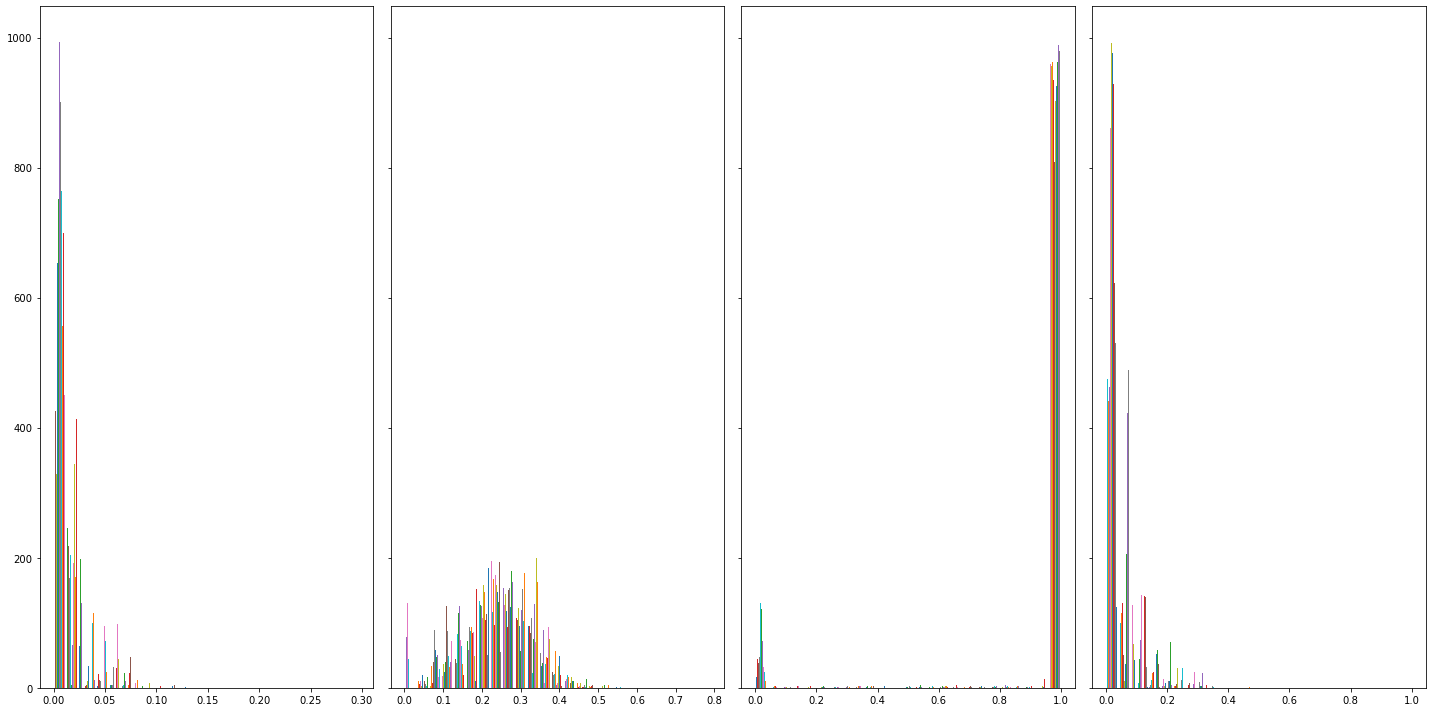

In [69]:
# plot a histogram of 4 bands

bandA = 0
bandB = 150
bandC = 300 
bandD = 400 

bandsToCheck = [
                refl_array[:,:,bandA],
                refl_array[:,:,bandB],
                #refl_array[:,:,bandC], # commented out to save some computation time if we don't need to look at all 4 bands
                #refl_array[:,:,bandD]
                ]

n_bins = 25
fig, axs = plt.subplots(1, len(bandsToCheck), figsize=(20, 10), sharey=True, tight_layout=True)

# We can set the number of bins with the `bins` kwarg
for i in range(len(bandsToCheck)):
    axs[i].hist(bandsToCheck[i], bins=n_bins)

plt.show()


It appears that the input file and functionality are working correctly at this point, based on the fact that all the bands are read in and they are unique.

-----------------------------------------------

#### Now to call the resampling function and observe the behaviour of the returned arrays bands

In [21]:
# parameter setup:

desired_GSD = 5 # GSD in m
desired_band_centres = [0.505, 0.526, 0.544, 0.565, 0.586, 0.606, 0.626, 0.646, 0.665, 0.682, 0.699, 0.715, 0.730, 0.745, 0.762, 0.779, 0.787, 0.804]
desired_band_centres_um = np.array(desired_band_centres) # band centres passed in as um instead of nm
desired_band_centres = np.array(desired_band_centres)*1000 # this is the nm fix line
print("Parameters set!")

Parameters set!


In [22]:
print('band centres nm: ',desired_band_centres) # look at input band centres
print('band centres um: ',desired_band_centres_um)

band centres nm:  [505. 526. 544. 565. 586. 606. 626. 646. 665. 682. 699. 715. 730. 745.
 762. 779. 787. 804.]
band centres um:  [0.505 0.526 0.544 0.565 0.586 0.606 0.626 0.646 0.665 0.682 0.699 0.715
 0.73  0.745 0.762 0.779 0.787 0.804]


In [23]:
# demonstrates error if non-scaled desired bands centres array passed in
downSampler.reband_spectral_array(refl_array[1,0,:], wavelength_array, desired_band_centres_um)

array([0.0124, 0.0124, 0.0124, 0.0124, 0.0124, 0.0124, 0.0124, 0.0124,
       0.0124, 0.0124, 0.0124, 0.0124, 0.0124, 0.0124, 0.0124, 0.0124,
       0.0124, 0.0124])

In [24]:
# demonstrates correct way with scaled desired bands centres array passed in
downSampler.reband_spectral_array(refl_array[1,0,:], wavelength_array, desired_band_centres)

array([0.02967327, 0.04347497, 0.05538264, 0.05628799, 0.04912016,
       0.04928713, 0.04675686, 0.04458939, 0.04286913, 0.04028501,
       0.07098625, 0.12477066, 0.18544582, 0.21921135, 0.23799551,
       0.24086497, 0.24210605, 0.24478618])

In [16]:
wavelength_array

array([ 381.6035,  386.6132,  391.6229,  396.6327,  401.6424,  406.6522,
        411.6619,  416.6716,  421.6814,  426.6911,  431.7008,  436.7106,
        441.7203,  446.7301,  451.7398,  456.7495,  461.7593,  466.769 ,
        471.7787,  476.7885,  481.7982,  486.808 ,  491.8177,  496.8274,
        501.8372,  506.8469,  511.8566,  516.8664,  521.8761,  526.8859,
        531.8956,  536.9053,  541.9151,  546.9248,  551.9345,  556.9443,
        561.954 ,  566.9638,  571.9735,  576.9832,  581.993 ,  587.0027,
        592.0124,  597.0222,  602.0319,  607.0416,  612.0514,  617.0611,
        622.0709,  627.0806,  632.0903,  637.1001,  642.1098,  647.1195,
        652.1293,  657.139 ,  662.1488,  667.1585,  672.1682,  677.178 ,
        682.1877,  687.1974,  692.2072,  697.2169,  702.2267,  707.2364,
        712.2461,  717.2559,  722.2656,  727.2753,  732.2851,  737.2948,
        742.3046,  747.3143,  752.324 ,  757.3338,  762.3435,  767.3532,
        772.363 ,  777.3727,  782.3825,  787.3922, 

In [25]:
desired_band_centres

resamp_refl_array = downSampler.downSample_reband_array(refl_array, metadata_dict['Spatial_Resolution_X_Y'][0], desired_GSD, wavelength_array, desired_band_centres_um) # downsample

resamp_metadata_dict = metadata_dict.copy()
resamp_metadata_dict['Spatial_Resolution_X_Y'] = [float(desired_GSD), float(desired_GSD)] # adjust resolution metadata to reflect downsampling
print("Downsampling Complete!")

Downsampling Complete!


### Checks on re-sampled array just processed from refl_array

In [26]:
resamp_refl_array

array([[[0.0109, 0.0109, 0.0109, ..., 0.0109, 0.0109, 0.0109],
        [0.0108, 0.0108, 0.0108, ..., 0.0108, 0.0108, 0.0108],
        [0.0106, 0.0106, 0.0106, ..., 0.0106, 0.0106, 0.0106],
        ...,
        [0.0049, 0.0049, 0.0049, ..., 0.0049, 0.0049, 0.0049],
        [0.0048, 0.0048, 0.0048, ..., 0.0048, 0.0048, 0.0048],
        [0.0047, 0.0047, 0.0047, ..., 0.0047, 0.0047, 0.0047]],

       [[0.0113, 0.0113, 0.0113, ..., 0.0113, 0.0113, 0.0113],
        [0.0111, 0.0111, 0.0111, ..., 0.0111, 0.0111, 0.0111],
        [0.011 , 0.011 , 0.011 , ..., 0.011 , 0.011 , 0.011 ],
        ...,
        [0.0049, 0.0049, 0.0049, ..., 0.0049, 0.0049, 0.0049],
        [0.0047, 0.0047, 0.0047, ..., 0.0047, 0.0047, 0.0047],
        [0.0046, 0.0046, 0.0046, ..., 0.0046, 0.0046, 0.0046]],

       [[0.0116, 0.0116, 0.0116, ..., 0.0116, 0.0116, 0.0116],
        [0.0115, 0.0115, 0.0115, ..., 0.0115, 0.0115, 0.0115],
        [0.0113, 0.0113, 0.0113, ..., 0.0113, 0.0113, 0.0113],
        ...,
        [0.0

In [84]:
# testing & error checking

def array_stats(input_array):
    print("Mean reflectance: "'{number:.{digits}f}'.format(number=input_array.mean(), digits=3))
    print("Std Dev.: "'{number:.{digits}f}'.format(number=input_array.std(), digits=3))
    print("Min reflectance: "'{number:.{digits}f}'.format(number=input_array.min(), digits=3))
    print("Max reflectance: "'{number:.{digits}f}'.format(number=input_array.max(), digits=3))
    print("-"*35)
    
resamp_bandA = 0
resamp_bandB = 5
resamp_bandC = 10
resamp_bandD = 15
    
array_stats(resamp_refl_array[:,:,resamp_bandA])
array_stats(resamp_refl_array[:,:,resamp_bandB])
array_stats(resamp_refl_array[:,:,resamp_bandC])
array_stats(resamp_refl_array[:,:,resamp_bandD])
print('-'*50)
print(resamp_refl_array[100:110,100:110,resamp_bandA])
print('-'*50)
print(resamp_refl_array[100:110,100:110,resamp_bandB])
print('-'*50)
print(resamp_refl_array[100:110,100:110,resamp_bandC])
print('-'*50)
print(resamp_refl_array[100:110,100:110,resamp_bandD])

Mean reflectance: 0.032
Std Dev.: 0.032
Min reflectance: 0.002
Max reflectance: 0.504
-----------------------------------
Mean reflectance: 0.050
Std Dev.: 0.042
Min reflectance: 0.004
Max reflectance: 0.556
-----------------------------------
Mean reflectance: 0.066
Std Dev.: 0.042
Min reflectance: 0.005
Max reflectance: 0.521
-----------------------------------
Mean reflectance: 0.308
Std Dev.: 0.099
Min reflectance: 0.004
Max reflectance: 0.736
-----------------------------------
--------------------------------------------------
[[0.1012 0.0934 0.0856 0.084  0.0824 0.0808 0.0792 0.0776 0.0871 0.0966]
 [0.1017 0.0948 0.0879 0.0856 0.0832 0.0809 0.0786 0.0762 0.0864 0.0966]
 [0.1023 0.0963 0.0902 0.0871 0.0841 0.081  0.0779 0.0748 0.0858 0.0967]
 [0.0997 0.094  0.0883 0.0858 0.0832 0.0806 0.0781 0.0755 0.0849 0.0943]
 [0.0971 0.0918 0.0865 0.0844 0.0824 0.0803 0.0782 0.0762 0.0841 0.092 ]
 [0.0944 0.0895 0.0846 0.0831 0.0815 0.0799 0.0784 0.0768 0.0832 0.0896]
 [0.0918 0.0873 0.0828 

In [85]:
# # resampled input image
# for band in range(resamp_refl_array.shape[2]):
#     print('Band: ', band)
#     print('Max: ', resamp_refl_array[:,:,band].max())
#     print('Min: ', resamp_refl_array[:,:,band].min())
#     print('Avg.: ', np.average(resamp_refl_array[:,:,band]))
#     print('Std.: ', np.std(resamp_refl_array[:,:,band]))

## __Test different file output formats__

In [88]:
# params
band_width_array = downSampler.band_widths(desired_band_centres)
band_width_array

array([21., 18., 21., 21., 20., 20., 20., 19., 17., 17., 16., 15., 15.,
       17., 17.,  8., 17., 17.])

## Array to Geotiff raster layer image:

This will let us test the output Geotiff images

In [90]:
# test it out and check outputs in QGIS
refl_arrayname_output =  str(Path(output_data_path / 'Debugging_Test_Geotiff'))
downSampler.array2gtiff_raster(resamp_refl_array, desired_band_centres_um, band_width_array, resamp_metadata_dict, 1, 1, output_data_path, refl_arrayname_output)

## Array to hdf5 raster layer image:

In [29]:
# save to raster hdf5
refl_arrayname_output =  Path(output_data_path / 'splitbands_output_Debugging_Test.h5')
downSampler.array2h5raster(resamp_refl_array, desired_band_centres, band_width_array, resamp_metadata_dict, refl_arrayname_output)

Band_001
Band_002
Band_003
Band_004
Band_005
Band_006
Band_007
Band_008
Band_009
Band_010
Band_011
Band_012
Band_013
Band_014
Band_015
Band_016
Band_017
Band_018


### Read in file and check bands

In [25]:
from osgeo import gdal
import numpy as np
temp_path = r'C:\Users\Chris\Documents\SideProjects_C\hyperspectral-project\data\Skywatch\catalog\WYVERN_DS_20210520T094044_C8ovySO_band_001.tif'

gtif = gdal.Open( temp_path )
band = gtif.GetRasterBand(1)
bandArray1 = band.ReadAsArray()
print(bandArray1)
print(np.max(bandArray1))
print(np.min(bandArray1))
print(np.mean(bandArray1))
gtif = None

[[0.0283 0.026  0.0236 ... 0.0682 0.0677 0.0673]
 [0.0295 0.0266 0.0237 ... 0.0679 0.0677 0.0676]
 [0.0308 0.0273 0.0238 ... 0.0677 0.0678 0.0678]
 ...
 [0.0279 0.0272 0.0264 ... 0.0162 0.02   0.0237]
 [0.0278 0.0274 0.027  ... 0.0176 0.0217 0.0258]
 [0.0276 0.0276 0.0277 ... 0.0189 0.0234 0.028 ]]
0.3691
0.0048
0.04041837


In [27]:
from osgeo import gdal
import numpy as np
temp_path = r'C:\Users\Chris\Documents\SideProjects_C\hyperspectral-project\data\Skywatch\catalog\WYVERN_DS_20210520T094044_C8ovySO_band_007.tif'

gtif = gdal.Open( temp_path )
band = gtif.GetRasterBand(1)
bandArray7 = band.ReadAsArray()
print(bandArray7)
print(np.max(bandArray7))
print(np.min(bandArray7))
print(np.mean(bandArray7))
gtif = None

[[0.0391 0.035  0.0309 ... 0.0935 0.0929 0.0923]
 [0.041  0.036  0.031  ... 0.0936 0.0934 0.0932]
 [0.0429 0.037  0.0311 ... 0.0937 0.0939 0.0941]
 ...
 [0.0392 0.0381 0.0369 ... 0.0193 0.0249 0.0305]
 [0.0391 0.0385 0.0379 ... 0.0216 0.0278 0.0339]
 [0.039  0.039  0.039  ... 0.0238 0.0306 0.0374]]
0.4042
0.0034
0.057678293


In [3]:
input_file_dict

{'NEON_D16_ABBY_DP3_552000_5071000_reflectance.h5': 'C:\\Users\\Chris\\Documents\\SideProjects_C\\hyperspectral-project\\data\\pipeline_input\\NEON.D16.ABBY.DP3.30006.001.2019-07.basic.20210211T072435Z.RELEASE-2021\\NEON_D16_ABBY_DP3_552000_5071000_reflectance.h5',
 'NEON_D16_ABBY_DP3_552000_5072000_reflectance.h5': 'C:\\Users\\Chris\\Documents\\SideProjects_C\\hyperspectral-project\\data\\pipeline_input\\NEON.D16.ABBY.DP3.30006.001.2019-07.basic.20210211T072435Z.RELEASE-2021\\NEON_D16_ABBY_DP3_552000_5072000_reflectance.h5',
 'NEON_D16_ABBY_DP3_552000_5073000_reflectance.h5': 'C:\\Users\\Chris\\Documents\\SideProjects_C\\hyperspectral-project\\data\\pipeline_input\\NEON.D16.ABBY.DP3.30006.001.2019-07.basic.20210211T072435Z.RELEASE-2021\\NEON_D16_ABBY_DP3_552000_5073000_reflectance.h5',
 'NEON_D16_ABBY_DP3_552000_5074000_reflectance.h5': 'C:\\Users\\Chris\\Documents\\SideProjects_C\\hyperspectral-project\\data\\pipeline_input\\NEON.D16.ABBY.DP3.30006.001.2019-07.basic.20210211T072435Z.

## -------------------------------------- WIP AFTER THIS POINT --------------------------------------

In [9]:
import time
for file_name, file_path in tqdm.tqdm(input_file_dict.items(), desc = "Processing"):
    time.sleep(1)

Processing: 100%|████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.01s/it]


In [ ]:
# test_ls = np.array([
#                    [[1,2,3,4],
#                     [2,3,4,5],
#                     [3,4,5,6],
#                     [4,5,6,7]],
    
#                    [[11,12,13,14],
#                     [12,13,14,15],
#                     [13,14,15,16],
#                     [14,15,16,17]],
    
#                    [[21,22,23,24],
#                     [22,23,24,25],
#                     [23,24,25,26],
#                     [24,25,26,27]],
    
#                    [[31,32,33,34],
#                     [32,33,34,35],
#                     [33,34,35,36],
#                     [34,35,36,37]],
    
#                     ])
# test_ls
# test_ls.shape
# test_ls[2,2,2]